##### Author: Matthew W. Boyce, PhD, 
##### Email: boyce.matthew@epa.gov

##### Version: 3.0 06-17-2021

##### Description:  
- This script reads the raw data files (.csv or .txt, depending on model) and and a user generated data that lists the metabolites identified in literature and potential markush dhild from those metabolites. The script then aggregates the data into a signle dataFrame, which is used by the GlobalComparison and LocalComparison notebooks to analyze the performance of the in silico prediction tools. The script is scalable and and can be expanded to include more or less metabolite software tools by changing the number of models inthe 'modelList' varible, enuring that the data of additional models are formatted with the correct titles (DTXSID, Metabolite_INCHIKEY, Clean_SMILES, var modelName).

##### Notes: 
- This script uses os, pandas, numpy, matplotlib, rdkit, sns, and Model_Comp
- This script pulls data from the root/data/raw directory

##### Potential issues: *None known*

#### Updates:
- Additional processing and analysis performed by Grace Patlewicz

In [1]:
import numpy as np
import os as os
import pandas as pd
import seaborn as sns
import sygma

from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import MolsToGridImage

from IPython.core.display import HTML

In [2]:
TOP = os.getcwd().replace('notebooks', '')

In [3]:
raw_dat_dir = TOP + 'data/raw/'
processed_dat_dir = TOP + 'data/processed/'
interim_dat_dir = TOP + 'data/interim/'
figures_dir = TOP + 'reports/figures/'
external_dir = TOP + 'data/external/'

In [4]:
import sys

sys.path.append(TOP + 'src/data/')

from model_comp import *

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Read and Clean <a class="anchor" id="first-bullet"></a>

#### Create a list of the metabolism in silico tools. This can be adjusted depending on the selected tools.

In [6]:
modelList = ['ToolBox', 'Meteor','BioTransformer','TIMES_InVivo','TIMES_InVitro', 'SyGMa', 'CTS'] 

#### Import the original csv file containing the ExpoCast substances downloaded from the EPA CompTox Chemicals dashboard
#### Generate two dictionaries for the normal and qsar ready InChI keys to link to DTXSIDs

In [7]:
DSSToxList = pd.read_csv(raw_dat_dir+"CompToxList.csv", header = 0)
DSSToxList = DSSToxList.rename(columns={'INCHIKEY':'Parent_INCHIKEY'})
DSSToxList['QSAR_READY_INCHIKEY'] = SMILES_to_InchiKey(DSSToxList['QSAR_READY_SMILES'],stereoisomer = False)
DSSToxList.to_csv(processed_dat_dir + 'Processed_CompToxList_v1.csv')
Norm_DTXSID_dict = dict(zip(DSSToxList['Parent_INCHIKEY'],DSSToxList['DTXSID']))
QSAR_DTXSID_dict = dict(zip(DSSToxList['QSAR_READY_INCHIKEY'],DSSToxList['DTXSID']))

In [8]:
DSSToxList.head()

,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,CASRN,Parent_INCHIKEY,SMILES,QSAR_READY_SMILES,QSAR_READY_INCHIKEY
0,DTXSID0044151,DSSTox_Substance_Id,DTXSID0044151,"3,5-Dinitroaniline",618-87-1,MPBZUKLDHPOCLS-UHFFFAOYSA-N,NC1=CC(=CC(=C1)[N+]([O-])=O)[N+]([O-])=O,NC1=CC(=CC(=C1)[N+]([O-])=O)[N+]([O-])=O,MPBZUKLDHPOCLS-UHFFFAOYSA-N
1,DTXSID6025725,DSSTox_Substance_Id,DTXSID6025725,3-Nitroaniline,99-09-2,XJCVRTZCHMZPBD-UHFFFAOYSA-N,NC1=CC(=CC=C1)[N+]([O-])=O,NC1=CC(=CC=C1)[N+]([O-])=O,XJCVRTZCHMZPBD-UHFFFAOYSA-N
2,DTXSID8031077,DSSTox_Substance_Id,DTXSID8031077,Curcumin,458-37-7,VFLDPWHFBUODDF-FCXRPNKRSA-N,COC1=CC(\C=C\C(=O)CC(=O)\C=C\C2=CC=C(O)C(OC)=C...,COC1=CC(C=CC(=O)CC(=O)C=CC2=CC(OC)=C(O)C=C2)=C...,VFLDPWHFBUODDF-UHFFFAOYSA-N
3,DTXSID1025726,DSSTox_Substance_Id,DTXSID1025726,2-Nitroaniline,88-74-4,DPJCXCZTLWNFOH-UHFFFAOYSA-N,NC1=CC=CC=C1[N+]([O-])=O,NC1=CC=CC=C1[N+]([O-])=O,DPJCXCZTLWNFOH-UHFFFAOYSA-N
4,DTXSID4025791,DSSTox_Substance_Id,DTXSID4025791,2-Nitrotoluene,88-72-2,PLAZTCDQAHEYBI-UHFFFAOYSA-N,CC1=CC=CC=C1[N+]([O-])=O,CC1=CC=CC=C1[N+]([O-])=O,PLAZTCDQAHEYBI-UHFFFAOYSA-N


#### Use model_comp.py functions to import and process raw data generated by each of the metabolite in silico tools 

In [9]:
toolBoxDF = ToolBox_cleanup(raw_dat_dir+'Toolbox_Report.csv', QSAR_DTXSID_dict)
meteorDF = Meteor_cleanup(raw_dat_dir+'Meteor_Report.csv')
bioTransformerDF = BioTransformer_cleanup(raw_dat_dir+'BioTransformer_Report.csv', Norm_DTXSID_dict)
times_inVivoDF = TIMES_cleanup(raw_dat_dir+'TIMES_010621_iv.csv', 'TIMES_InVivo', header = 0)[['DTXSID','Metabolite_INCHIKEY','Clean_SMILES', 'TIMES_InVivo']]
times_inVitroDF = TIMES_cleanup(raw_dat_dir+'TIMES_010621_ivt.csv', 'TIMES_InVitro')[['DTXSID','Metabolite_INCHIKEY','Clean_SMILES', 'TIMES_InVitro']]
ctsDF = CTS_cleanup(raw_dat_dir+'CTS_All_Report.csv', QSAR_DTXSID_dict)

#### Generate SyGMa metabolites in notebook and using function to return appropriately formatted DF

In [10]:
if(not os.path.exists(raw_dat_dir + 'SyGMa_Data.csv')):
    sygmaDF = gen_sygma_metabolites_DF(DSSToxList['SMILES'], Norm_DTXSID_dict, pathways = [[sygma.ruleset['phase1'], 2],[sygma.ruleset['phase2'],1]])
    sygmaDF.to_csv(raw_dat_dir + 'SyGMa_Data.csv')
    
sygmaDF = pd.read_csv(raw_dat_dir + 'SyGMa_Data.csv')

#### Import reported metabolites from the file exported by ChemReg and a file relating InChI keys to DTXSIDs

In [11]:
litDF = genLiteratureDF(raw_dat_dir+'ExpocastMetab_CompiledLit.csv', raw_dat_dir+'DTXSID_Markush_Final.csv')

#### Dataframe generated for each prediction software

In [12]:
meteorDF

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,Meteor
1,DTXSID0020151,QTBSBXVTEAMEQO-UHFFFAOYSA-N,CC(=O)O,1
2,DTXSID0020151,WVDDGKGOMKODPV-UHFFFAOYSA-N,OCc1ccccc1,1
3,DTXSID0020151,WPYMKLBDIGXBTP-UHFFFAOYSA-N,O=C(O)c1ccccc1,1
4,DTXSID0020151,QIAFMBKCNZACKA-UHFFFAOYSA-N,O=C(O)CNC(=O)c1ccccc1,1
6,DTXSID0020151,BJUXDERNWYKSIQ-UHFFFAOYSA-N,CC(=O)NC(CSCc1ccccc1)C(=O)O,1
...,...,...,...,...
1497,DTXSID9047251,GFMAFYNUQDLPBP-UHFFFAOYSA-N,NC1CCCNC1c1ccccc1,1
1498,DTXSID9047251,LMBJRHZWRSEWFS-UHFFFAOYSA-N,COc1cc(O)c(OC(F)(F)F)cc1C(=O)O,1
1499,DTXSID9047251,GGEVMSCGYXHFKD-UHFFFAOYSA-N,COc1cc(O)c(OC(F)(F)F)cc1CO,1
1500,DTXSID9047251,ANOWPINBSXXOTC-UHFFFAOYSA-N,COc1c(O)cc(OC(F)(F)F)cc1CNC1CCCNC1c1ccccc1,1


In [13]:
bioTransformerDF

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,BioTransformer
0,DTXSID0044151,QXYMVUZOGFVPGH-UHFFFAOYSA-N,NC1=C(O)C([N+](=O)[O-])=CC([N+](=O)[O-])=C1,1
2,DTXSID0044151,TTXPIURLJOPGTE-UHFFFAOYSA-N,NC1=CC([N+](=O)[O-])=C(O)C([N+](=O)[O-])=C1,1
3,DTXSID0044151,WSIDAANKKVDFNY-UHFFFAOYSA-N,O=[N+]([O-])C1=CC(NO)=CC([N+](=O)[O-])=C1,1
6,DTXSID0044151,OQLXBGXMCLUSAC-UHFFFAOYSA-N,NC1=C(O)C([N+](=O)[O-])=CC([N+](=O)[O-])=C1O,1
8,DTXSID0044151,ZVFXOCHWBWRBDV-UHFFFAOYSA-N,NC1=CC([N+](=O)[O-])=C(O)C([N+](=O)[O-])=C1O,1
...,...,...,...,...
1645,DTXSID0020575,FHEHIXJLCWUPCZ-UHFFFAOYSA-N,C=CCC1=CC(O)=C(O)C=C1,1
1646,DTXSID0020575,NQRRYLLAQLTROY-UHFFFAOYSA-N,COC1=CC=C(C(O)C2CO2)C=C1,1
1647,DTXSID0020575,DFTIORCOZJOMGW-UHFFFAOYSA-N,OC1=CC=C(CC2CO2)C=C1,1
1652,DTXSID2026781,HEZKKXXTBTXSBU-UHFFFAOYSA-N,CC(C)CC(C)OC1OC(C(=O)O)C(O)C(O)C1O,1


In [14]:
times_inVivoDF

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,TIMES_InVivo
1,DTXSID0044151,DFWXYHZQNLIBLY-UHFFFAOYSA-N,Nc1cc(N)cc([N+](=O)[O-])c1,1
2,DTXSID0044151,VAWNHKFFVKBVAD-UHFFFAOYSA-N,CC(=O)Nc1cc(N)cc([N+](=O)[O-])c1,1
3,DTXSID0044151,ZXERTWPNZJETAC-UHFFFAOYSA-N,CC(=O)Nc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1,1
4,DTXSID0044151,PXGZIPCHTTVSHD-UHFFFAOYSA-N,O=C(O)C1OC(Nc2cc([N+](=O)[O-])cc([N+](=O)[O-])...,1
6,DTXSID6025725,WZCQRUWWHSTZEM-UHFFFAOYSA-N,Nc1cccc(N)c1,1
...,...,...,...,...
602,DTXSID9047251,IPUSCDNYJLMMAI-UHFFFAOYSA-N,COc1ccc(OC(F)(F)F)cc1CNC1C(=O)CCNC1c1ccccc1,1
603,DTXSID9047251,BHKXCCGIASFIEN-UHFFFAOYSA-N,COc1ccc(OC(F)(F)F)cc1CNC1C(OC2OC(C(=O)O)C(O)C(...,1
604,DTXSID9047251,CWSJTTLDBJHBES-UHFFFAOYSA-N,COc1ccc(OC(F)(F)F)cc1CNC1CCCNC1c1ccc(O)cc1,1
605,DTXSID9047251,RTTDQFAYKYKOIR-UHFFFAOYSA-N,COc1ccc(OC(F)(F)F)cc1CNC1CCCNC1c1ccc(OC2OC(C(=...,1


In [15]:
times_inVitroDF

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,TIMES_InVitro
2,DTXSID0044151,DFWXYHZQNLIBLY-UHFFFAOYSA-N,Nc1cc(N)cc([N+](=O)[O-])c1,1
3,DTXSID0044151,RPHKINMPYFJSCF-UHFFFAOYSA-N,Nc1cc(N)cc(N)c1,1
4,DTXSID0044151,VUCKZBYGRGKCCQ-UHFFFAOYSA-N,Nc1cc(NO)cc([N+](=O)[O-])c1,1
5,DTXSID0044151,WSIDAANKKVDFNY-UHFFFAOYSA-N,O=[N+]([O-])c1cc(NO)cc([N+](=O)[O-])c1,1
6,DTXSID0044151,KOYVANKECFLLSD-UHFFFAOYSA-N,O=[N+]([O-])c1cc(NOS(=O)(=O)O)cc([N+](=O)[O-])c1,1
...,...,...,...,...
316,DTXSID9047251,XNEQHGJZPNQJPO-UHFFFAOYSA-N,COc1ccc(OC(F)(F)F)cc1CNC1C(O)CCNC1c1ccc(O)cc1,1
317,DTXSID9047251,OVYFGQACZWJVLO-UHFFFAOYSA-N,COc1ccc(OC(F)(F)F)cc1CNC1C(O)CCNC1c1ccc(OC2OC(...,1
318,DTXSID9047251,JKQSBWAPMDSUJS-UHFFFAOYSA-N,COc1ccc(OC(F)(F)F)cc1CNC1C(OC2OC(C(=O)O)C(O)C(...,1
319,DTXSID9047251,LCYXJQLQOKHPDD-UHFFFAOYSA-N,COc1ccc(OC(F)(F)F)cc1CNC1C(O)CCNC1c1ccccc1,1


In [16]:
ctsDF

,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,CTS
1,DTXSID0044151,DFWXYHZQNLIBLY-UHFFFAOYSA-N,Nc1cc(N)cc([N+](=O)[O-])c1,1
2,DTXSID0044151,RPHKINMPYFJSCF-UHFFFAOYSA-N,Nc1cc(N)cc(N)c1,1
3,DTXSID0044151,SUYLOMATYCPVFT-UHFFFAOYSA-N,Nc1cc(N)c(O)c(N)c1,1
4,DTXSID0044151,WFNVGXBEWXBZPL-UHFFFAOYSA-N,Nc1cc(N)cc(O)c1,1
5,DTXSID0044151,VKFBRTZWQOUOSP-UHFFFAOYSA-N,Nc1cc(N)cc(NO)c1,1
...,...,...,...,...
919,DTXSID8021482,LCTONWCANYUPML-UHFFFAOYSA-N,CC(=O)C(=O)O,1
920,DTXSID8021482,BSABBBMNWQWLLU-UHFFFAOYSA-N,CC(O)C=O,1
921,DTXSID8021482,RXKJFZQQPQGTFL-UHFFFAOYSA-N,O=C(CO)CO,1
922,DTXSID8021482,PEDCQBHIVMGVHV-UHFFFAOYSA-N,OCC(O)CO,1


In [17]:
sygmaDF

,Unnamed: 0,DTXSID,Metabolite_INCHIKEY,Clean_SMILES,SyGMa
0,1,DTXSID0044151,ZXERTWPNZJETAC-UHFFFAOYSA-N,CC(=O)Nc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1,1
1,2,DTXSID0044151,TTXPIURLJOPGTE-UHFFFAOYSA-N,Nc1cc([N+](=O)[O-])c(O)c([N+](=O)[O-])c1,1
2,3,DTXSID0044151,QXYMVUZOGFVPGH-UHFFFAOYSA-N,Nc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1O,1
3,4,DTXSID0044151,DFWXYHZQNLIBLY-UHFFFAOYSA-N,Nc1cc(N)cc([N+](=O)[O-])c1,1
4,5,DTXSID0044151,DJJDJEGEEBJYIT-UHFFFAOYSA-N,CC(=O)Nc1cc([N+](=O)[O-])c(O)c([N+](=O)[O-])c1,1
...,...,...,...,...,...
5210,5247,DTXSID8021482,ZHFQGMZFDJMJMH-UHFFFAOYSA-N,O=C(CO)COS(=O)(=O)O,1
5211,5248,DTXSID8021482,NNGULBKCRXZDOX-UHFFFAOYSA-N,O=C(O)C(=O)C(=O)OC1OC(C(=O)O)C(O)C(O)C1O,1
5212,5249,DTXSID8021482,BGSLMLAAOXUBIR-UHFFFAOYSA-N,O=C(O)CNC(=O)C(=O)CO,1
5213,5250,DTXSID8021482,KPSYTBWKMLWIKT-UHFFFAOYSA-N,O=C(O)C(=O)COS(=O)(=O)O,1


In [18]:
litDF

,DTXSID,Metabolite_INCHIKEY,Reported,Metabolite DTXSID,Markush
0,DTXSID1025726,DPJCXCZTLWNFOH-UHFFFAOYSA-N,1,DTXSID1025726,False
1,DTXSID1025726,VEHLRRUCQAPNIT-QUARPLMYSA-N,1,DTXSID101025802,False
2,DTXSID1025726,WHODQVWERNSQEO-UHFFFAOYSA-N,1,DTXSID6020064,False
3,DTXSID1025726,IQXUIDYRTHQTET-UHFFFAOYSA-N,1,DTXSID50209864,False
4,DTXSID1025726,VZLLZDZTQPBHAZ-UHFFFAOYSA-N,1,DTXSID3060669,False
...,...,...,...,...,...
824,DTXSID9020374,HGEVTAPPAACBMY-UHFFFAOYSA-N,1,DTXSID001026021,True
825,DTXSID9020374,PZQUTPXIDGQKFZ-RXQGYGPJSA-N,1,DTXSID301026018,True
826,DTXSID9020374,QVFZTWYKFIHJIH-RXQGYGPJSA-N,1,DTXSID301026018,True
827,DTXSID9020374,ANXAJOROVVKRQP-UHFFFAOYSA-N,1,DTXSID301026020,True


#### Generate list of the dataframes containing the cleaned data then aggregate the data into a single dataframe: agg_Data
#### Note: In the aggregate data, each software has its own column with a 1 or 0, which indicates that the software predicted or did not predict that metabolite

In [19]:
dfList = [toolBoxDF, meteorDF, bioTransformerDF,times_inVivoDF, times_inVitroDF, sygmaDF, ctsDF, litDF]
agg_Data = aggregate_DFs(dfList)

agg_Data['Metabolite DTXSID'].replace(0, 'NA', inplace = True)
agg_Data['Markush'].replace(0, False, inplace = True)

agg_Data.sort_values(by='DTXSID')

,DTXSID,Metabolite_INCHIKEY,ToolBox,Meteor,BioTransformer,TIMES_InVivo,TIMES_InVitro,Unnamed: 0,SyGMa,CTS,Reported,Metabolite DTXSID,Markush
2995,DTXSID0020151,ZENOXNGFMSCLLL-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,1221.0,1.0,0.0,0.0,NA,False
3047,DTXSID0020151,JKVTYDWBQZINOG-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,1276.0,1.0,0.0,0.0,NA,False
3046,DTXSID0020151,DJXKLNTTXTZFOU-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,1275.0,1.0,0.0,0.0,NA,False
3045,DTXSID0020151,HQOQYSHOHJLNDC-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,1274.0,1.0,0.0,0.0,NA,False
3044,DTXSID0020151,IHFPLGRHJDIZLM-UHFFFAOYSA-N,0.0,0.0,0.0,0.0,0.0,1273.0,1.0,0.0,0.0,NA,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6873,DTXSID9047251,LTZOPGHYQXKKJE-BNMUKHHWSA-N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DTXSID201024964,True
6874,DTXSID9047251,NGYLHVIZQVWSDZ-XPORZQOISA-N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DTXSID601025033,False
6875,DTXSID9047251,SQBCTTVGKCSVTP-OALUTQOASA-N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,DTXSID001025035,False
1541,DTXSID9047251,ODJFVPUECORNMZ-YQBZFSLMSA-N,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NA,False


#### Check aggregated dataframe to see if there are any duplicated pairings of Parent DTXSID - Metabolite InChiKeys

In [20]:
DTXSID_Metab_pairings = list(zip(agg_Data['DTXSID'],agg_Data['Metabolite_INCHIKEY']))
[(i,DTXSID_Metab_pairings.index(DTXSID_Metab_pairings[i]), DTXSID_Metab_pairings[i]) for i in range(len(DTXSID_Metab_pairings)) if not i == DTXSID_Metab_pairings.index(DTXSID_Metab_pairings[i])]

[]

<AxesSubplot:ylabel='DTXSID'>

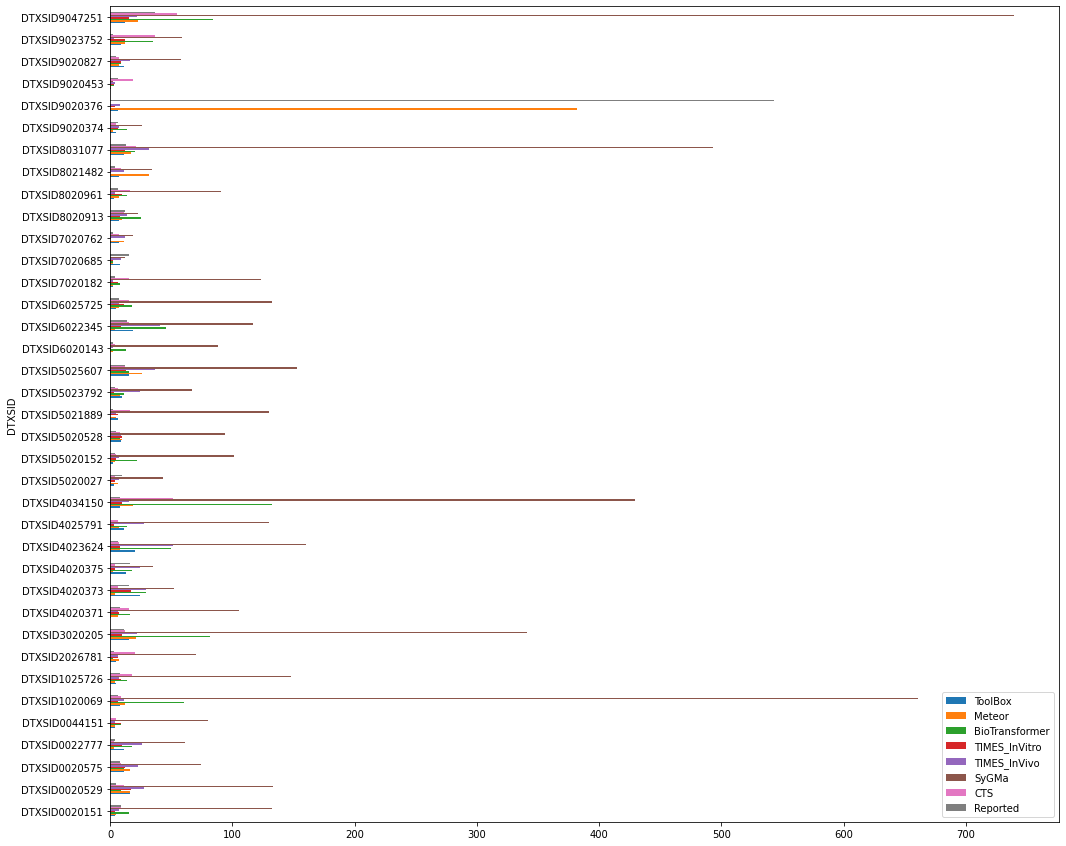

In [21]:
agg_Data.groupby('DTXSID').agg({'ToolBox': 'sum', 'Meteor' :'sum','BioTransformer': 'sum','TIMES_InVitro':'sum','TIMES_InVivo':'sum','SyGMa':'sum','CTS':'sum', 'Reported':'sum'}).plot.barh(figsize = (17,15))

In [22]:
grpby = agg_Data.groupby('DTXSID').agg({'ToolBox': 'sum', 'Meteor' :'sum','BioTransformer': 'sum','TIMES_InVitro':'sum','TIMES_InVivo':'sum','SyGMa':'sum','CTS':'sum', 'Reported':'sum'})
grpby.describe()

,ToolBox,Meteor,BioTransformer,TIMES_InVitro,TIMES_InVivo,SyGMa,CTS,Reported
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,8.486486,19.297297,22.351351,7.648649,15.405405,140.945946,12.756757,22.216216
std,5.600702,61.732337,27.775105,4.296098,12.216700,171.918415,12.037916,88.236153
min,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000
25%,5.000000,4.000000,8.000000,4.000000,7.000000,52.000000,6.000000,4.000000
50%,8.000000,7.000000,14.000000,8.000000,11.000000,91.000000,9.000000,6.000000
75%,11.000000,12.000000,22.000000,10.000000,24.000000,132.000000,15.000000,11.000000
max,24.000000,382.000000,132.000000,17.000000,51.000000,739.000000,55.000000,543.000000


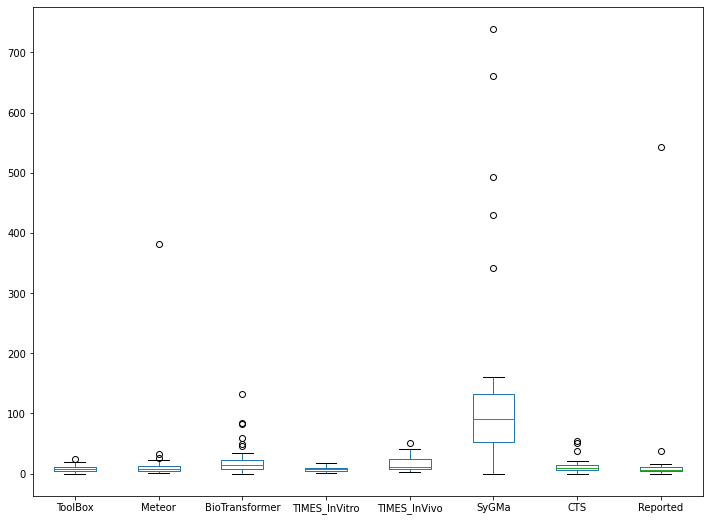

In [23]:
grpby[grpby.columns.tolist()].plot(kind = 'box', figsize = (12,9))

plt.savefig(figures_dir+'BoxPlot_Metabolite_count.png', dpi = 300)

In [24]:
agg_Data.to_csv(processed_dat_dir + r'\Cleaned_AggregateData.csv')